### Learn a differential equation 

* $f(x) = \frac{dx}{dt}$

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable 
import torch.nn.functional as F

%matplotlib inline 

### The idea

In this experiment we want to see if we can learn a differential equation of the form $\frac{dx}{dt}=f(x)$. We want to take an appraoch where we are learning the integral of $\frac{dx}{dt}$, resulting in a $x$ value, and then differentiating that learned $x$ with finite difference to get a learned $\frac{dx}{dt}$ value. We can them compute a loss based on the analytic value of $f$, which we have as a function, on the learned $x$ and the finite difference version of $\frac{dx}{dt}$.  This forces $\frac{dx}{dt}$ to become close to $f(x)$, which will hopefully result in a learned $x$ that is the integral of $\frac{dx}{dt}$ and satisfies $\frac{dx}{dt}=f(x)$.

We want to set up a system where the network takes in some initial $t$ values  and learns the $x$ s.t. that $x$ is the solution to $f(x)=\frac{dx}{dt}$

We will try to learn the following equation:

* Equation: $\frac{dx}{dt} = 2x$
* Solution: $x(t) = Ce^{2t}$


In [28]:
# Helper functions
def dxdt(x,t):
    """ Use a 1D conv to take the partial derivative dx/dt """
    var_x = x.view(1,1,-1)
    var_t = t.view(1,1,-1)
    weights = Variable(torch.Tensor([1,-1]).view(1,1,-1),requires_grad=False)
    
    deriv = torch.div(F.conv1d(var_x,weights), F.conv1d(var_t,weights))
    
    last_elm = (var_x[:,:,-2]-var_x[:,:,-1])/(var_t[:,:,-2]-var_t[:,:,-1])
    total_deriv = torch.cat([deriv,last_elm.view(1,1,-1)],dim=2)
    return total_deriv.view(-1,1)


In [ ]:
# Network structure
class XGen(nn.Module):
    """ Generative model for the X values s.t. they solve dx/dt = f(x) """
    def __init__(self, indim):
        super(XGen,self).__init__()
        self.deconv1 = nn.ConvTranspose1d(1,10,kernel_size=1)
        self.deconv2 = nn.ConvTranspose1d(10,10,kernel_size=2)
        self.deconv3 = nn.ConvTranspose1d(10,20,kernel_size=2)
        self.linear = nn.Linear(20*(indim+2),1)
        
    def forward(self,t):
        var = F.leaky_relu(self.deconv1(t),0.05)
        var = F.leaky_relu(self.deconv2(var),0.05)
        var = F.leaky_relu(self.deconv3(var),0.05)
        x = self.linear(var.view(var.size(0),-1))
        return x
    
class Analytic(nn.Module):
    """ Generative model for the X values s.t. they solve dx/dt = f(x) """
    def __init__(self, indim):
        super(Analytic,self).__init__()
        self.linear3 = nn.Linear(10,1)
        
    def forward(self,t):
        x = torch.exp(2.0*t)
        return x
    
 

### Training and Results

As you can see below it looks like the model converges.  A few things to note here, the `big_lam` value is just arbitrarily large because we want to enforce the initial condition that is given in the $x_0$ term both with respect to the learned $x_0$ and the learned $f(x_0)$.  Also note that we only run $t$ values on $[-1,1]$ because the finite difference error blows up because the analytic solution is exponentiated. 

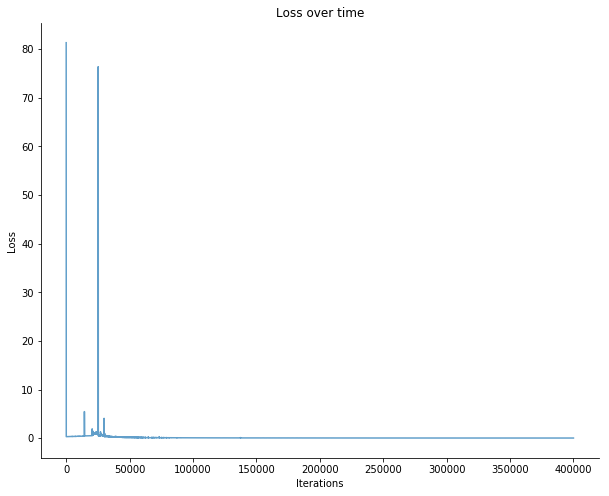

In [33]:
   
def train(net, opt, loss_func, t_in, f, epochs=10, use_cuda=False):
    """ Train the model """
    losses, itr, big_lam, t_first = [], 0, 1000, t_in.ravel()[0]
    
    if use_cuda:
        t_tensor = Variable(torch.Tensor(t_in).cuda(),requires_grad=True) 
    else:
        t_tensor = Variable(torch.Tensor(t_in),requires_grad=True) 
        
    for e in range(epochs):
        opt.zero_grad()

        x_est = net(t_tensor)
        fx_est = dxdt(x_est,t_tensor)
        
        # Force initial conditions 
        x_est_copy = x_est.clone()
        x_est_copy[0] = np.exp(2.0*t_first)

        # Calculate the real f(x)
        fx_true = Variable(f(x_est_copy.data).cuda()) if use_cuda else Variable(f(x_est_copy.data))

        # Calculate the loss
        loss = loss_func(fx_est, fx_true) + big_lam*torch.pow(x_est[0]-np.exp(2.0*t_first),2) \
                                          + big_lam*torch.pow(fx_est[0]-f(np.exp(2.0*t_first)),2) 
 
        # Backprop and update
        loss.backward()
        opt.step()
        itr+=1
        losses.append(loss)
            
    losses = [i.data.cpu().numpy()[0] for i in losses] if use_cuda else [i.data.numpy()[0] for i in losses]
    return range(itr),losses
            

use_cuda = torch.cuda.is_available()

np.random.seed(42)
f = lambda x: 2.0*x

# Params
n_examples = 100

# Set up the data 
t = np.linspace(-1,1,n_examples).reshape(-1,1,1)

# Set up model      
# net = Analytic(1).cuda() if use_cuda else Analytic(1)
net = XGen(1).cuda() if use_cuda else XGen(1)
opt = optim.SGD(net.parameters(),lr=1e-4,weight_decay=0.01)
loss_func = nn.MSELoss()

# Train the model 
itr, losses = train(net, opt, loss_func, t, f, epochs=400000, use_cuda=use_cuda)

# Look at plot of loss 
plt.figure(figsize=(10,8))
plt.plot(itr,losses,alpha=0.7)
plt.title('Loss over time')
plt.ylabel('Loss')
plt.xlabel('Iterations')
sns.despine()

### How did we do?

These results look great! It not only learned a valid $\frac{dx}{dt}=f(x)$ but it also learned a $x$ that is remarkably close to the analytic solution. 

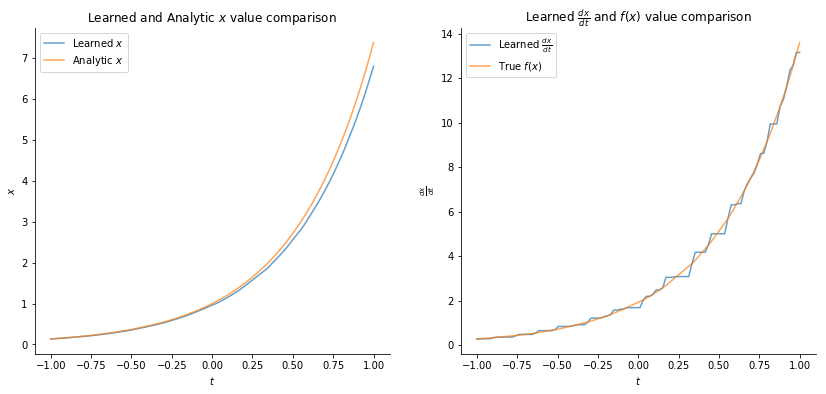

In [34]:
# Calculate values 
t_ex = t
learned_x = net(Variable(torch.Tensor(t_ex)))
learned_dxdt = dxdt(learned_x,Variable(torch.Tensor(t_ex)))
analytic_x = np.exp(2.0*t_ex)
analytic_fx = 2.0*learned_x.data.numpy()

# Plotting 
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,6))

# Plot X 
ax1.plot(t_ex.ravel(), learned_x.data.numpy().ravel(), alpha=0.7, label=r'Learned $x$')
ax1.plot(t_ex.ravel(), analytic_x.ravel(), alpha=0.7, label=r'Analytic $x$')
ax1.set_title(r'Learned and Analytic $x$ value comparison')
ax1.set_xlabel(r'$t$')
ax1.set_ylabel(r'$x$')
ax1.legend()

# Plot dx/dt and f(x) where x is the learned value
ax2.plot(t_ex.ravel(), learned_dxdt.data.numpy().ravel(), alpha=0.7,label=r'Learned $\frac{dx}{dt}$')
ax2.plot(t_ex.ravel(), analytic_fx.ravel(), alpha=0.7,label=r'True $f(x)$')
ax2.set_title(r'Learned $\frac{dx}{dt}$ and $f(x)$ value comparison')
ax2.set_xlabel(r'$t$')
ax2.set_ylabel(r'$\frac{dx}{dt}$')
ax2.legend()

sns.despine()

### Loss value (MSE):

In [35]:
# Calculate the loss
fx_true = Variable(f(learned_x.data))
print('Loss:',loss_func(learned_dxdt,fx_true).data.numpy()[0])

Loss: 0.0245714


### Examples of analytic solution compared with the learned $x$

In [36]:
t_new = np.array([.2,.3,.4]).reshape(-1,1,1)
print('Learned x:',net(Variable(torch.Tensor(t_new))).data.numpy().ravel())
print('Analytic x:', np.exp(2.0*t_new).ravel())

Learned x: [ 1.42474532  1.73142171  2.10196257]
Analytic x: [ 1.4918247   1.8221188   2.22554093]


## A faulty example:

Let's try a example with something that is decaying, such as $\frac{dx}{dt}=-2x$.

The below model just runs the same structure and training procedure on $f(x)=-2x$

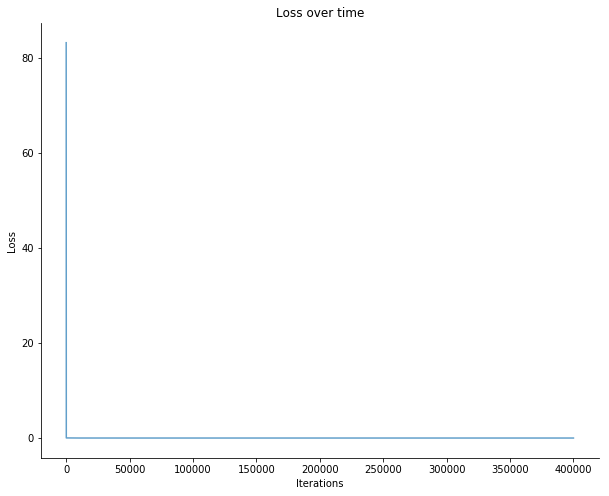

In [39]:
np.random.seed(42)
f_2 = lambda x: -2.0*x

# Params
n_examples = 100

# Set up the data 
t_2 = np.linspace(-1,1,n_examples).reshape(-1,1,1)

# Set up model      
# net = Analytic(1).cuda() if use_cuda else Analytic(1)
net_2 = XGen(1).cuda() if use_cuda else XGen(1)
opt_2 = optim.SGD(net_2.parameters(),lr=1e-4,weight_decay=0.01)
loss_func = nn.MSELoss()

# Train the model 
itr2, losses2 = train(net_2, opt_2, loss_func, t_2, f_2, epochs=400000, use_cuda=use_cuda)

# Look at plot of loss 
plt.figure(figsize=(10,8))
plt.plot(itr2,losses2,alpha=0.7)
plt.title('Loss over time')
plt.ylabel('Loss')
plt.xlabel('Iterations')
sns.despine()

### Results

The results here are a little strange.  The model seems to do an acceptable job of learning $\frac{dx}{dt}=f(x)$ but it does not learn the intermediate $x$ value to correctly approximate the analytic solution to the differential equation. 

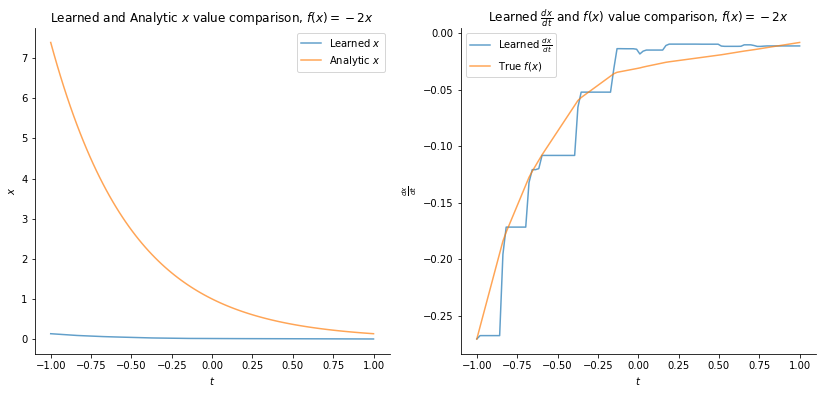

In [40]:
# Calculate values 
t_ex = t_2
learned_x = net_2(Variable(torch.Tensor(t_ex)))
learned_dxdt = dxdt(learned_x,Variable(torch.Tensor(t_ex)))
analytic_x = np.exp(-2.0*t_ex)
analytic_fx = -2.0*learned_x.data.numpy()

# Plotting 
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,6))

# Plot X 
ax1.plot(t_ex.ravel(), learned_x.data.numpy().ravel(), alpha=0.7, label=r'Learned $x$')
ax1.plot(t_ex.ravel(), analytic_x.ravel(), alpha=0.7, label=r'Analytic $x$')
ax1.set_title(r'Learned and Analytic $x$ value comparison, $f(x)=-2x$')
ax1.set_xlabel(r'$t$')
ax1.set_ylabel(r'$x$')
ax1.legend()

# Plot dx/dt and f(x) where x is the learned value
ax2.plot(t_ex.ravel(), learned_dxdt.data.numpy().ravel(), alpha=0.7,label=r'Learned $\frac{dx}{dt}$')
ax2.plot(t_ex.ravel(), analytic_fx.ravel(), alpha=0.7,label=r'True $f(x)$')
ax2.set_title(r'Learned $\frac{dx}{dt}$ and $f(x)$ value comparison, $f(x)=-2x$')
ax2.set_xlabel(r'$t$')
ax2.set_ylabel(r'$\frac{dx}{dt}$')
ax2.legend()

sns.despine()

### Learning the $\frac{dx}{dt}$ kernel:

Here we will try to learn a kernel for higher order differentiation accuracy.  The first approach we take will modify the finite difference convolution kernel from $[1,-1]$ to a parametric $[k_0,1,-1,k_1]$. We hold the center two values constant with a hook that zeros the gradient to the center $[1,-1]$ kernel and let the $k_0,k_1$ parameters vary. 


In [222]:
def dxdt_learn_kernel(x,t,weights):
    """ Use a 1D conv to take the partial derivative dx/dt """
    var_x = x.view(1,1,-1)
    var_t = t.view(1,1,-1)
    
    deriv = torch.div(F.conv1d(F.pad(var_x,(1,1)),weights), F.conv1d(F.pad(var_t,(1,1)),weights))
    last_elm = (var_x[:,:,-2]-var_x[:,:,-1])/(var_t[:,:,-2]-var_t[:,:,-1])
    total_deriv = torch.cat([deriv,last_elm.view(1,1,-1)],dim=2)
    return total_deriv.view(-1,1)

def train_learn_kernel(net, opt, loss_func, t_in, f, epochs=10, use_cuda=False):
    """ Train the model """
    losses, itr, big_lam, t_first = [], 0, 1000, t_in.ravel()[0]
    
    if use_cuda:
        t_tensor = Variable(torch.Tensor(t_in).cuda(),requires_grad=True) 
    else:
        t_tensor = Variable(torch.Tensor(t_in),requires_grad=True) 
        
    for e in range(epochs):
        opt.zero_grad()

        x_est = net(t_tensor)
        fx_est = dxdt_learn_kernel(x_est, t_tensor, net.ww)
        
        # Force initial conditions 
        x_est_copy = x_est.clone()
        x_est_copy[0] = np.exp(2.0*t_first)

        # Calculate the real f(x)
        fx_true = Variable(f(x_est_copy.data).cuda()) if use_cuda else Variable(f(x_est_copy.data))

        # Calculate the loss
        loss = loss_func(fx_est, fx_true) + big_lam*torch.pow(x_est[0]-np.exp(2.0*t_first),2) \
                                          + big_lam*torch.pow(fx_est[0]-f(np.exp(2.0*t_first)),2) \
                                                                          
        # Backprop and update
        loss.backward()
        opt.step()
        itr+=1
        losses.append(loss)
            
    losses = [i.data.cpu().numpy()[0] for i in losses] if use_cuda else [i.data.numpy()[0] for i in losses]
    return range(itr),losses

### Results:

We expect this approach to blow up, and it certainly does as you can see from the plot of the low function below. We expect it to blow up because the model has enough freedom with the two paraemters in the differentiation kernel to allow the gradient to explode as the $k_0$ and $k_1$ parameters try to adjust to make everything zero. 

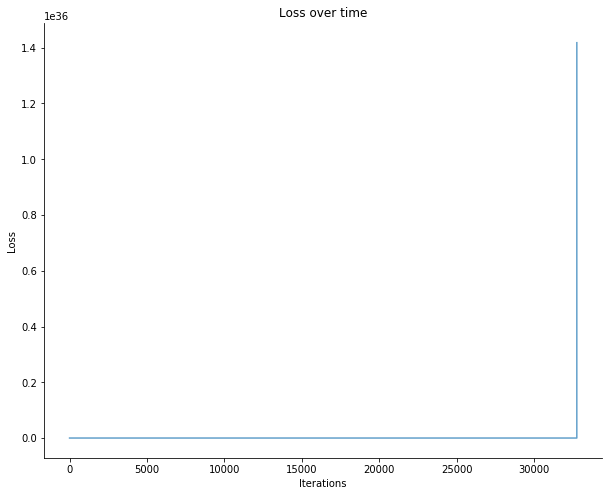

In [223]:
use_cuda = torch.cuda.is_available()

np.random.seed(42)
f = lambda x: 2.0*x

# Params
n_examples = 100

# Set up the data 
t = np.linspace(-1,1,n_examples).reshape(-1,1,1)

# Set up model      
weights = torch.Tensor([0.01,1,-1,0.01]).view(1,1,-1)

net = XGen(1).cuda() if use_cuda else XGen(1)
net.ww = nn.Parameter(weights)

# Register hook to mask the inner differentiation kernel
def hooker(grad):
    mask = Variable(torch.Tensor([1.0,0.0,0.0,1.0]).view(1,1,-1),requires_grad=False)
    return mask*grad
hk = net.ww.register_hook(hooker)

# Get optimizer and loss
opt = optim.SGD(net.parameters(),lr=1e-4,weight_decay=0.01)
loss_func = nn.MSELoss()

# Train the model 
itr, losses = train_learn_kernel(net, opt, loss_func, t, f, epochs=100000, use_cuda=use_cuda)

# Look at plot of loss 
plt.figure(figsize=(10,8))
plt.plot(itr,losses,alpha=0.7)
plt.title('Loss over time')
plt.ylabel('Loss')
plt.xlabel('Iterations')
sns.despine()

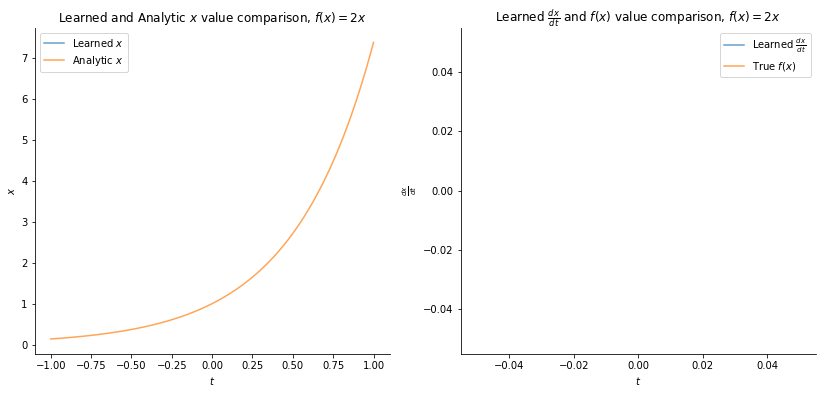

In [224]:
# Calculate values 
t_ex = t
learned_x = net(Variable(torch.Tensor(t_ex)))
learned_dxdt = dxdt_learn_kernel(learned_x,Variable(torch.Tensor(t_ex)), net.ww)
analytic_x = np.exp(2.0*t_ex)
analytic_fx = 2.0*learned_x.data.numpy()

# Plotting 
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,6))

# Plot X 
ax1.plot(t_ex.ravel(), learned_x.data.numpy().ravel(), alpha=0.7, label=r'Learned $x$')
ax1.plot(t_ex.ravel(), analytic_x.ravel(), alpha=0.7, label=r'Analytic $x$')
ax1.set_title(r'Learned and Analytic $x$ value comparison, $f(x)=2x$')
ax1.set_xlabel(r'$t$')
ax1.set_ylabel(r'$x$')
ax1.legend()

# Plot dx/dt and f(x) where x is the learned value
ax2.plot(t_ex.ravel(), learned_dxdt.data.numpy().ravel(), alpha=0.7,label=r'Learned $\frac{dx}{dt}$')
ax2.plot(t_ex.ravel(), analytic_fx.ravel(), alpha=0.7,label=r'True $f(x)$')
ax2.set_title(r'Learned $\frac{dx}{dt}$ and $f(x)$ value comparison, $f(x)=2x$')
ax2.set_xlabel(r'$t$')
ax2.set_ylabel(r'$\frac{dx}{dt}$')
ax2.legend()

sns.despine()

In [225]:
print('Value of learned kernel letting the first and last parameter vary:\n\n',net.ww)

Value of learned kernel letting the first and last parameter vary:

 Parameter containing:
(0 ,.,.) = 
 nan nan nan nan
[torch.FloatTensor of size 1x1x4]



### Learning the $\frac{dx}{dt}$ kernel:

Here we will try to learn a kernel for higher order differentiation accuracy with a slight modification to our strategy.  In this approach we take will modify the finite difference convolution kernel from $[1,-1]$ to a parametric $[k_0,1,-1,-k_0]$. We hold the center two values constant with a hook that zeros the gradient to the center $[1,-1]$ kernel and let the $k_0$ parameter vary. We hold $k_0$ equal to itself in the kernel by making the update gradients equal and negatives of each other for $k_0$ and $-k_0$ (see the registered hook function `hooker` below for details). This version has a better chance of being stable than the above version. 


Note that while it has a better chance of being stable, it is still slightly unstable and suffers from the exploding gradient problem on occasional training runs.  This problem could be solved with some form of regularization like gradient clipping. 

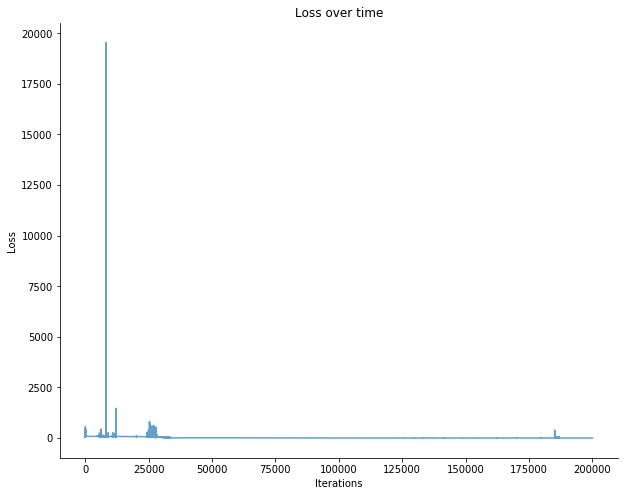

In [267]:
def train_learn_kernel_const(net, opt, loss_func, t_in, f, epochs=10, use_cuda=False):
    """ Train the model """
    losses, itr, big_lam, t_first = [], 0, 1000, t_in.ravel()[0]
    weight_arr = []
    if use_cuda:
        t_tensor = Variable(torch.Tensor(t_in).cuda(),requires_grad=True) 
    else:
        t_tensor = Variable(torch.Tensor(t_in),requires_grad=True) 
        
    for e in range(epochs):
        opt.zero_grad()

        x_est = net(t_tensor)
        fx_est = dxdt_learn_kernel(x_est, t_tensor, net.ww)
        
        # Force initial conditions 
        x_est_copy = x_est.clone()
        x_est_copy[0] = np.exp(2.0*t_first)

        # Calculate the real f(x)
        fx_true = Variable(f(x_est_copy.data).cuda()) if use_cuda else Variable(f(x_est_copy.data))

        # Calculate the loss
        weight_arr.append(net.ww[0,0,0].data.numpy()[0])
        loss = loss_func(fx_est, fx_true) + big_lam*torch.pow(x_est[0]-np.exp(2.0*t_first),2) \
                                          + big_lam*torch.pow(fx_est[0]-f(np.exp(2.0*t_first)),2) \
                                            
        # Backprop and update
        loss.backward()
        opt.step()
        itr+=1
        losses.append(loss)
            
    losses = [i.data.cpu().numpy()[0] for i in losses] if use_cuda else [i.data.numpy()[0] for i in losses]
    return range(itr),losses, weight_arr


use_cuda = torch.cuda.is_available()

np.random.seed(42)
f = lambda x: 2.0*x

# Params
n_examples = 100

# Set up the data 
t = np.linspace(-1,1,n_examples).reshape(-1,1,1)

# Set up model      
weights = torch.Tensor([0.01,1,-1,-0.01]).view(1,1,-1)

net = XGen(1).cuda() if use_cuda else XGen(1)
net.ww = nn.Parameter(weights)

# Register hook to mask the inner differentiation kernel
def hooker(grad):
    # Mask for the center two values 
    mask = Variable(torch.Tensor([1.0,0.0,0.0,0.0]).view(1,1,-1), requires_grad=False)
    masked_grad = mask*grad
    
    # Constraint where in [k_0,k_1,k_2,k_3] kernel k_0==-k_3 by forcing the 
    # gradients to be grad(k_0)==-grad(k_3)
    masked_grad[0,0,3] = -masked_grad[0,0,0]
    return masked_grad

hk = net.ww.register_hook(hooker)

# Get optimizer and loss 
opt = optim.SGD(net.parameters(),lr=1e-4,weight_decay=0.0)
loss_func = nn.MSELoss()

# Train the model 
itr, losses, diff_kernel_w = train_learn_kernel_const(net, opt, loss_func, t, f, epochs=200000, use_cuda=use_cuda)

# Look at plot of loss 
plt.figure(figsize=(10,8))
plt.plot(itr,losses,alpha=0.7)
plt.title('Loss over time')
plt.ylabel('Loss')
plt.xlabel('Iterations')
sns.despine()

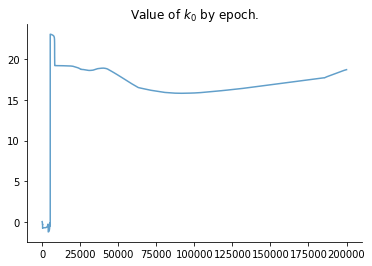

In [268]:
# Plot differentiation kernel weight 
plt.plot(diff_kernel_w, alpha=0.7)
plt.title('Value of $k_0$ by epoch.');
sns.despine()

### Results 

These results are a little strange.  Again, the model learns $\frac{dx}{dt} =f(x)$ very well, but it learns an $x$ value that is not at all close to the analytic solution. 

The one parameter in the kernel overpowers the differentiation in the center of the kernel and learns something that is not modeling the system as we would hope. 

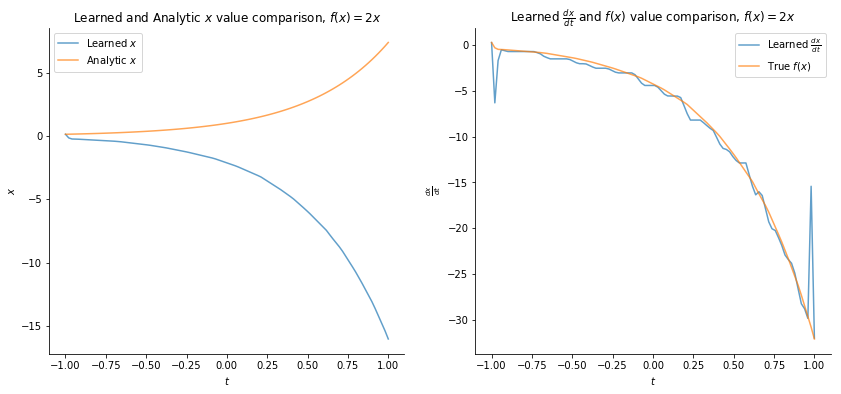

In [269]:
# Calculate values 
t_ex = t
learned_x = net(Variable(torch.Tensor(t_ex)))
learned_dxdt = dxdt_learn_kernel(learned_x,Variable(torch.Tensor(t_ex)), net.ww)
analytic_x = np.exp(2.0*t_ex)
analytic_fx = 2.0*learned_x.data.numpy()

# Plotting 
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,6))

# Plot X 
ax1.plot(t_ex.ravel(), learned_x.data.numpy().ravel(), alpha=0.7, label=r'Learned $x$')
ax1.plot(t_ex.ravel(), analytic_x.ravel(), alpha=0.7, label=r'Analytic $x$')
ax1.set_title(r'Learned and Analytic $x$ value comparison, $f(x)=2x$')
ax1.set_xlabel(r'$t$')
ax1.set_ylabel(r'$x$')
ax1.legend()

# Plot dx/dt and f(x) where x is the learned value
ax2.plot(t_ex.ravel(), learned_dxdt.data.numpy().ravel(), alpha=0.7,label=r'Learned $\frac{dx}{dt}$')
ax2.plot(t_ex.ravel(), analytic_fx.ravel(), alpha=0.7,label=r'True $f(x)$')
ax2.set_title(r'Learned $\frac{dx}{dt}$ and $f(x)$ value comparison, $f(x)=2x$')
ax2.set_xlabel(r'$t$')
ax2.set_ylabel(r'$\frac{dx}{dt}$')
ax2.legend()

sns.despine()

In [271]:
print('Value of learned kernel letting the first parameter vary:\n\n',net.ww)

Value of learned kernel letting the first parameter vary:

 Parameter containing:
(0 ,.,.) = 
  18.7300   1.0000  -1.0000 -18.7300
[torch.FloatTensor of size 1x1x4]



### Future work:

This project is just a proof of concept. 

So far we showed that we can learn to integrate a $\frac{dx}{dt}$ to get a $x$ s.t. it satisfies $\frac{dx}{dt}=f(x)$, non-trivially. However, we only showed this for a incresing differential equation of the form $f(x)=2x$.  The decaying equation $f(x)=-2x$ did not find a valid integration of $\frac{dx}{dt}$.  A natural extention to this is to try other values and forms of $f(x)$ in the model.  This will be a important step in really understanding how well this method learns to integrate $\frac{dx}{dt}$.

Furthermore, we also experimented with learning additional parameters to the finite difference kernel.  We used only a length 4 kernel in a 1D convolution first with two free parameters and second with just one free parameter.  The method with two parameters was highly unstable and did not work. The second method interestingly learned a different $x$ which was non-trivial, but not the normal integral solution. A natural extension to this would be to try different kernels and see if the model can learn a higher order differentation method. 

Finally, I think the main thing that needs to be done is running more experiments with different types of differential equations. 